In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dft_ad
from pyscfad import gto as gto_ad
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision


from xcquinox import net
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Compute inputs

In [2]:
#training and validation values
inds, vals, tflats, vflats = gen_grid_s(npts = 1e5)
train_inds, val_inds = inds
rv, grv, sv = vals
trf, tgrf, tsf = tflats
vrf, vgrf, vsf = vflats
#training and validation values for SIGMA
sinds, svals, stflats, svflats = gen_grid_s(npts = 1e5, sigma=True)
strain_inds, sval_inds = sinds
srv, sgrv, ssv = svals
strf, stgrf, stsf = stflats
svrf, svgrf, svsf = svflats

shapes- r/gr/s: (315,)/(315,)/(315,)
shapes- r/gr/s: (315,)/(315,)/(315,)


In [3]:
ref_fx = PBE_Fx(trf, tgrf)
ref_fc = PBE_Fc(trf, tgrf)

siginputs = jnp.stack([strf, stgrf], axis=1)


In [4]:
#sigma-based networks
spbe_fx = net.GGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
spbe_fc = net.GGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

In [5]:
#create optimizers
soptimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
soptimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)
spt_pbe_fx = Pretrainer(model = spbe_fx, optim = soptimizer_fx, inputs = siginputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
spt_pbe_fc = Pretrainer(model = spbe_fc, optim = soptimizer_fc, inputs = siginputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)



In [6]:
# snmx, snlx = spt_pbe_fx()
# snmc, snlc = spt_pbe_fc()

In [7]:
# net.save_xcquinox_model(snmx, path='pretrained_test', loss=snlx)
# net.save_xcquinox_model(snmc, path='pretrained_test', loss=snlc)

In [8]:
snmx = net.load_xcquinox_model('pretrained_test/GGA_FxNet_sigma_d3_n16_s92017')
snmc = net.load_xcquinox_model('pretrained_test/GGA_FcNet_sigma_d3_n16_s92017')
snlx = np.loadtxt('pretrained_test/GGA_FxNet_sigma_d3_n16_s92017_loss.txt')
snlc = np.loadtxt('pretrained_test/GGA_FcNet_sigma_d3_n16_s92017_loss.txt')

Loaded pretrained_test/GGA_FxNet_sigma_d3_n16_s92017.eqx
Loaded pretrained_test/GGA_FcNet_sigma_d3_n16_s92017.eqx


In [ ]:
def custom_pbe_Fx(rho, sigma, XNET = None):
    #this will be a call to the Fx neural network we want
    # print('DEBUG custom_pbe_Fx, rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG custom_pbe_Fx: rho: ', rho)
    # print('DEBUG custom_pbe_Fx: sigma: ', sigma)

    Fx = XNET([rho, sigma])
    return Fx

def custom_pbe_Fc(rho, sigma, CNET = None): #Assumes zeta = 0
    #this will be a call to the Fc neural network we want
    Fc = CNET([rho, sigma])
    return Fc

def custom_pbe_e(rho, sigma, XNET = None, CNET = None):
    Fx = custom_pbe_Fx(rho, sigma, XNET = XNET)
    Fc = custom_pbe_Fc(rho, sigma, CNET = CNET)

    exc = lda_x(rho)*Fx + pw92c_unpolarized(rho)*Fc

    return exc

def custom_pbe_epsilon(rho, sigma, XNET = None, CNET = None):

    return rho*custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_e(rhosigma, XNET = None, CNET = None):
    rho, sigma = rhosigma
    # print('DEBUG derivable_custom_pbe_e: rhosigma len/shapes: ', len(rhosigma), rhosigma)
    # print('DEBUG derivable_custom_pbe_e: rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG derivable_custom_pbe_e: rho: ', rho)
    # print('DEBUG derivable_custom_pbe_e: sigma: ', sigma)
    return custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_epsilon(rhosigma, XNET = None, CNET = None):
    rho = rhosigma[0]
    sigma = rhosigma[1]
    result = custom_pbe_epsilon(rho, sigma, XNET = XNET, CNET = CNET)
    return result[0]
    
def eval_xc_gga_j(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 XNET = None, CNET = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    rho0, dx, dy, dz = rho[:4]
    rho0 = jnp.array(rho0)
    sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    rhosig = (rho0, sigma)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    derivable_net_e = partial(derivable_custom_pbe_e, XNET = XNET, CNET = CNET)
    derivable_net_epsilon = partial(derivable_custom_pbe_epsilon, XNET = XNET, CNET = CNET)
    exc = np.array(jax.vmap(derivable_net_e)( rhosig ) )
    
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(derivable_net_epsilon)
    vrhosigma = np.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[0], vrhosigma[1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(derivable_net_epsilon)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = np.array(jax.vmap(v2_f)( rhosig ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[0][0]
    v2rhosigma = v2[0][1]
    v2sigma2 = v2[1][1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

def eval_xc_gga_j2(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 xcmodel = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    try:
        rho0, dx, dy, dz = rho[:4]
        sigma = jnp.array(dx**2+dy**2+dz**2)
    except:
        rho0, drho = rho[:4]
        sigma = jnp.array(drho**2)
    rho0 = jnp.array(rho0)
    # sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    # rhosig = (rho0, sigma)
    rhosig = jnp.stack([rho0, sigma], axis=1)
    # print(rhosig.shape)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    exc = jax.vmap(xcmodel)(rhosig)
    exc = jnp.array(exc)/rho0
    # exc = jnp.array(jax.vmap(xcmodel)( rhosig ) )/rho0
    # print('exc shape = {}'.format(exc.shape))
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(xcmodel)
    vrhosigma = jnp.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[:, 0], vrhosigma[:, 1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(xcmodel)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = jnp.array(jax.vmap(v2_f)( rhosig ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[:, 0, 0]
    v2rhosigma = v2[:, 0, 1]
    v2sigma2 = v2[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc


In [10]:
mol = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
mf = dft_ad.RKS(mol)
mf.grids.level = 1
mf.xc = 'pbe'
mf.kernel()
start_hf = scf.RHF(mol)
start_hf.kernel()
cc_h2o = cc.CCSD(start_hf)
cc_h2o.kernel()


Initialize <pyscfad.gto.mole.Mole object at 0x7d47888e0910> in <pyscfad.dft.rks.RKS object at 0x7d4790164dc0>
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute _enuc because it is not JSON-serializable
  warnings.warn(msg)


(-0.21334324588829434,
 array([[ 6.32837811e-05, -8.47932985e-17, -4.50170180e-17,
         -4.60673625e-05,  7.40241332e-05,  1.68008201e-18,
         -3.57169714e-17,  9.19758904e-05,  1.06918237e-19,
          1.68669258e-19, -1.86187389e-04,  4.91671389e-18,
         -3.13160448e-17,  8.62713654e-05,  5.62618060e-19,
         -5.41144556e-19, -5.87393933e-06,  3.21678470e-05,
         -3.41634937e-17],
        [-3.91228510e-03,  2.30519499e-16, -1.68882568e-16,
          3.57507648e-05, -4.24256897e-03, -4.06080911e-17,
         -1.32475712e-16, -3.68473231e-04, -3.53680400e-18,
         -1.21950773e-17, -1.47203123e-03,  2.39129287e-16,
         -9.55774457e-17,  2.67542416e-03, -1.73804426e-17,
          2.62552817e-18, -1.07208920e-04,  9.07975760e-04,
          2.61391067e-17],
        [-2.45613418e-16, -5.94474731e-03,  1.84260436e-03,
          2.91332512e-18,  2.85737121e-16, -7.46474077e-17,
         -4.54656237e-03,  3.03875265e-16,  2.28332957e-17,
          5.08534709e-1

In [11]:
#generate CCSD density using DFT coordinates and CCSD density matrix.
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=2)
CCSD_COORDS = np.array(mf.grids.coords)
ccsd_dm = cc_h2o.make_rdm1()
rho = dft_ad.numint.eval_rho(mol, jnp.array(ao), jnp.array(ccsd_dm), xctype='MGGA')
target_rho_CCSD = jnp.array(rho[0]).flatten()
TARGET_ENERGY = cc_h2o.e_tot

In [12]:
@eqx.filter_value_and_grad
def opt_loss_TE_rho(model, mols, refs):
    WEIGHT_E = 1.0
    WEIGHT_RHO = 20.0
    total_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
        dm = mf.make_rdm1()
        rho = dft_ad.numint.eval_rho(mol, jnp.array(ao), dm, xctype='GGA')[0].flatten()
        loss_E = abs(mf.e_tot - refs[idx][0])
        loss_rho = (1/mol.nelectron)*jnp.sum(mf.grids.weights*jnp.sqrt((rho - refs[idx][1])**2))
        total_loss += WEIGHT_E * loss_E + WEIGHT_RHO * loss_rho
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

In [23]:
class RXCModel(eqx.Module):
    xnet: eqx.Module
    cnet: eqx.Module

    def __init__(self, xnet, cnet):
        self.xnet = xnet
        self.cnet = cnet
        
    def __call__(self, inputs):
        #this generate epsilon, not exc -- divide end result by rho when needed
        rho = inputs[0]
        sigma = inputs[1]
        # print('RXCModel call - inputs {}'.format(inputs))
        return rho*(lda_x(rho)*jax.vmap(self.xnet)(inputs[..., jnp.newaxis]) + pw92c_unpolarized(rho)*jax.vmap(self.cnet)(inputs[..., jnp.newaxis])).flatten()[0]
        # return rho*(lda_x(rho)*self.xnet(inputs) + pw92c_unpolarized(rho)*self.cnet(inputs)).flatten()[0]
# Saving trained models
from typing import Union
import json
from xcquinox.net import load_xcquinox_model

def save_eqx_XC_model(model, path: str = '', fixing: Union[str, None] = None,
                   tail_info: Union[str, None] = None,
                   loss: Union[list[float], None] = None):
    if fixing is None:
        fixing = ''
    else:
        fixing = f'_{fixing}'
    if tail_info is None:
        tail_info = ''
    else:
        tail_info = f'_{tail_info}'
    model_x = model.xnet
    save_name_x = f'{model_x.name}_d{model_x.depth}_n{model_x.nodes}_s{model_x.seed}\
{fixing}{tail_info}'

    needen_info_x = {'depth': model_x.depth, 'nodes': model_x.nodes,
                   'seed': model_x.seed, 'name': model_x.name}
    eqx.tree_serialise_leaves(f'{path}/{save_name_x}.eqx', model_x)
    with open(f"{path}/{save_name_x}.json", "w") as f:
        json.dump(needen_info_x, f)
    model_c = model.cnet
    save_name_c = f'{model_c.name}_d{model_c.depth}_n{model_c.nodes}_s{model_c.seed}\
{fixing}{tail_info}'
    needen_info_c = {'depth': model_c.depth, 'nodes': model_c.nodes,
                   'seed': model_c.seed, 'name': model_c.name}
    eqx.tree_serialise_leaves(f'{path}/{save_name_c}.eqx', model_c)
    with open(f"{path}/{save_name_c}.json", "w") as f:
        json.dump(needen_info_c, f)
    needen_info = {'xnet': save_name_x, 'cnet': save_name_c}
    save_name_xc = f'model_xc{fixing}{tail_info}'
    with open(f"{path}/{save_name_xc}.json", "w") as f:
        json.dump(needen_info, f)

    if loss is not None:
        with open(f"{path}/{save_name_xc}_loss.txt", "w") as f:
            np.savetxt(f, loss)
            print(f'Saved the loss values in {path}/{save_name_xc}_loss.txt')
def load_eqx_XC_model(model_xc_path):
    
    with open(f"{model_xc_path}.json", "r") as f:
        metadata = json.load(f)
    path = model_xc_path.split('/')
    path = '/'.join(path[:-1])
    model_x = load_xcquinox_model(f'{path}/{metadata["xnet"]}')
    model_c = load_xcquinox_model(f'{path}/{metadata["cnet"]}')
    model = RXCModel(model_x, model_c)
    return model

In [14]:
from typing import Callable

class Optimizer(eqx.Module):
    model: eqx.Module
    optim: optax.GradientTransformation
    steps: int
    print_every: int
    opt_state: tuple
    mols: list
    refs: jnp.array
    loss: Callable

    def __init__(self, model, optim, mols, refs, loss, steps=1000, print_every=100):
        '''
        The Pretrainer object aids in the initial pre-training of enhancement factor networks to have a more physical starting point for further network optimization. This class is meant to pre-train a randomly initialized network to fit the values of a specific XC functional's enhancement factor (either X or C, in principle it could also be a combined XC enhancement facator)

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param optim: The optimizer than will control the weight updates given a loss and gradient
        :type optim: optax.GradientTransformation
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param loss: A function from :xcquinox.loss: that is decorated with @eqx.filter_value_and_grad
        :type loss: Callable
        :param steps: Number of epochs to train over, defaults to 1000
        :type steps: int, optional
        :param print_every: How often to print loss statistic, defaults to 100
        :type print_every: int, optional
        '''
        super().__init__()
        self.model = model
        self.optim = optim
        self.mols = mols
        self.refs = refs
        self.steps = steps
        self.print_every = print_every
        self.opt_state = self.optim.init(eqx.filter(self.model, eqx.is_array))
        self.loss = loss

    def __call__(self):
        '''
        The training loop itself. Here, a loop over the specifed epochs takes place to train the network to fit reference values.

        :return: The trained model and an array of the losses during training.
        :rtype: (:xcquinox.net: class, array)
        '''
        losses = []
        for epoch in range(self.steps):
            if epoch == 0:
                this_model = self.model
                this_opt_state = self.opt_state
            loss, this_model, this_opt_state = self.make_step(this_model, self.mols, self.refs, this_opt_state)
            lossi = loss.item()
            losses.append(lossi)
            if epoch % self.print_every == 0:
                print(f'Epoch {epoch}: Loss = {lossi}')

        return this_model, losses

    # @eqx.filter_jit
    def make_step(self, model, inputs, ref, opt_state):
        '''
        The function that does each epoch's network update. It generates a loss and gradient using the specific :xcquinox.loss: function (that must be decorated with @eqx.filter_value_and_grad and only explicitly returns the loss value inside the function proper) given the specified inputs and reference values and initial optimization state.

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param opt_state: The INITIAL optimization state to work against, typically generated via :self.optim.init(eqx.filter(self.model, eqx.is_array)):
        :type opt_state: The type of the above
        :return: The loss value for this step, the updated model after that loss is calculated, and the new optimization state for this step to use next time
        :rtype: tuple
        '''
        loss, grad = self.loss(model, self.mols, self.refs)
        updates, opt_state = self.optim.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state


In [15]:
test_model = RXCModel(xnet=snmx, cnet=snmc)

In [16]:
mol_ad = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol_ad.max_memory = 32000
mol_ad.build()
mol_ad.verbose = 0
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-5
OPTSTEPS = 100
OPTDECAYBEGIN = 30
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)
opt_opt = optax.adam(learning_rate=scheduler)
opt_snmxc = Optimizer(model=test_model, optim=opt_opt, mols = [mol_ad], refs = [[TARGET_ENERGY, target_rho_CCSD]], loss=opt_loss_TE_rho, print_every=1, steps=OPTSTEPS)

In [17]:
import warnings
warnings.filterwarnings("ignore")
#a lot of "derivative wrt the leaves not taken" printouts from pyscfad -- suppress that so we can actually see the losses easily

In [18]:
osnmxc, osnmxcl = opt_snmxc()

Epoch 0: Loss = 8.830795339651011
Epoch 1: Loss = 8.840422780997555
Epoch 2: Loss = 8.85092469128421
Epoch 3: Loss = 8.853432239905196
Epoch 4: Loss = 8.851209646572539
Epoch 5: Loss = 8.845775361600277
Epoch 6: Loss = 8.838114233434954
Epoch 7: Loss = 8.839537811861424
Epoch 8: Loss = 8.845081307429757
Epoch 9: Loss = 8.848242546310608
Epoch 10: Loss = 8.849707479895763
Epoch 11: Loss = 8.850003413718806
Epoch 12: Loss = 8.85126758790615
Epoch 13: Loss = 8.853487338580681
Epoch 14: Loss = 8.854730249828993
Epoch 15: Loss = 8.855096409404451
Epoch 16: Loss = 8.854712891596108
Epoch 17: Loss = 8.853723581849671
Epoch 18: Loss = 8.852281364409311
Epoch 19: Loss = 8.851597475061128
Epoch 20: Loss = 8.851744741112544
Epoch 21: Loss = 8.851242868432525
Epoch 22: Loss = 8.850057636032762
Epoch 23: Loss = 8.848185824887008
Epoch 24: Loss = 8.845640955713467
Epoch 25: Loss = 8.8424512397292
Epoch 26: Loss = 8.841405166643703
Epoch 27: Loss = 8.842241104203044
Epoch 28: Loss = 8.844718628627163

In [24]:
save_eqx_XC_model(osnmxc, path='trained_XC_test', tail_info='rho_PBE', loss=osnmxcl)


Saved the loss values in trained_XC_test/model_xc_rho_PBE_loss.txt


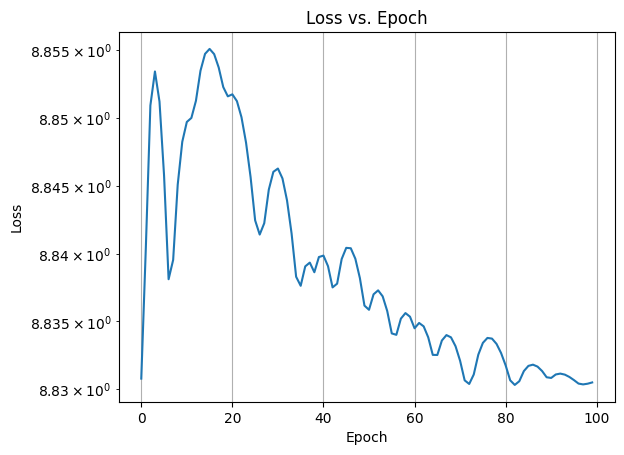

In [19]:
plt.plot(osnmxcl)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.yscale('log')
plt.grid()
plt.show()

## Training with pretrained by Sara
Sara: I will use the case of my pretrained networks, and my own eval_xc (as my networks expect as inputs rho and grad_rho)


In [35]:



def eUEG_LDA_c(rho):
    """Perdew-Wang 1992 correlation energy density for unpolarized case.
    """
    # Ensure rho is a jax.numpy array
    rho = jnp.asarray(rho)

    # Parameters from Table I of Perdew & Wang, PRB, 45, 13244 (92)
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370, 0.20548, 0.11125])
    BETA1 = jnp.array([7.5957, 14.1189, 10.357])
    BETA2 = jnp.array([3.5876, 6.1977, 3.6231])
    BETA3 = jnp.array([1.6382, 3.3662, 0.88026])
    BETA4 = jnp.array([0.49294, 0.62517, 0.49671])

    # Compute rs (Wigner-Seitz radius) for each grid point
    rs = (3 / (4 * jnp.pi * rho))**(1/3)
    # Convert rs to an array if it is a scalar
    rs = jnp.atleast_1d(rs)

    # Compute G for unpolarized case (zeta = 0) across all grid points
    def compute_g(rs):
        G = jnp.zeros((len(rs), 3))
        for k in range(3):
            B = (BETA1[k] * jnp.sqrt(rs) +
                 BETA2[k] * rs +
                 BETA3[k] * rs**1.5 +
                 BETA4[k] * rs**2)
            C = 1 + 1 / (2 * A[k] * B)
            G = G.at[:, k].set(-2 * A[k] * (1 + ALPHA1[k] * rs) * jnp.log(C))
        return G if rs.shape[0] > 1 else G[0]

    # Apply compute_g to each grid point
    G = compute_g(rs)
    # For unpolarized case, correlation energy density is G[0]
    EC = G[:, 0] if rs.shape[0] > 1 else G[0]

    return EC


def eUEG_LDA_x(rho):
    return -3/4*(3/jnp.pi)**(1/3)*jnp.sign(rho) * (jnp.abs(rho)) ** (1 / 3)


def eval_xc_PBE_general_Sara(xc_code, rho, spin=0, relativity=0, deriv=1,
                        omega=None, verbose=None,
                        xcmodel=None):
    """ With networks that expect rho and grad rho - the derivatives here must still be wrt sigma"""
    rho0, dx, dy, dz = rho[:4]
    sigma = (dx ** 2 + dy ** 2 + dz ** 2)
    if xcmodel is None:
        raise ValueError("xcmodel must be provided")
    def xcmodel_sigma(rho0, sigma):
        grad_rho = jnp.sqrt(sigma)
        if rho0.ndim == 0:
            rhogradrho = jnp.array([rho0, grad_rho])
        else:
            rhogradrho = jnp.stack([rho0, grad_rho], axis=-1)
        return xcmodel(rhogradrho)


    # Calculate the "custom" energy with rho -- THIS IS e
    exc = jax.vmap(xcmodel_sigma)(rho0, sigma)
    exc = jnp.array(exc) / rho0

    vrho, vsigma = jax.vmap(
        jax.grad(xcmodel_sigma, argnums=(0, 1)))(rho0, sigma)

    # # The outputs are expected to be numpy arrays
    # exc = np.asarray(exc)
    # vrho = np.asarray(vrho)
    # vsigma = np.asarray(vsigma)
    # print('VSIGMA', vsigma)

    vxc = (vrho, vsigma, None, None)
    fxc = None
    kxc = None

    return exc, vxc, fxc, kxc


In [36]:
# loss with my eval_xc
@eqx.filter_value_and_grad
def opt_loss_TE_rho_Sara(model, mols, refs):
    WEIGHT_E = 1.0
    WEIGHT_RHO = 20.0
    total_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_PBE_general_Sara, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
        dm = mf.make_rdm1()
        rho = dft_ad.numint.eval_rho(mol, jnp.array(ao), dm, xctype='GGA')[0].flatten()
        loss_E = abs(mf.e_tot - refs[idx][0])
        loss_rho = (1/mol.nelectron)*jnp.sum(mf.grids.weights*jnp.sqrt((rho - refs[idx][1])**2))
        total_loss += WEIGHT_E * loss_E + WEIGHT_RHO * loss_rho
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

In [21]:
fcnet_sara = net.load_xcquinox_model('pretrained_sara/GGA_FcNet_G_d3_n16_s42_v_8000')
fxnet_sara = net.load_xcquinox_model('pretrained_sara/GGA_FxNet_G_d3_n16_s42_v_8000')


Loaded pretrained_sara/GGA_FcNet_G_d3_n16_s42_v_8000.eqx
Loaded pretrained_sara/GGA_FxNet_G_d3_n16_s42_v_8000.eqx


In [22]:
test_model_sara = RXCModel(xnet=fxnet_sara, cnet=fcnet_sara)

In [37]:
mol_ad = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol_ad.max_memory = 32000
mol_ad.build()
mol_ad.verbose = 0
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-5
OPTSTEPS = 100
OPTDECAYBEGIN = 30
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)
opt_opt = optax.adam(learning_rate=scheduler)
opt_sara_v8000 = Optimizer(model=test_model_sara, optim=opt_opt, mols = [mol_ad], refs = [[TARGET_ENERGY, target_rho_CCSD]], loss=opt_loss_TE_rho_Sara, print_every=1, steps=OPTSTEPS)

In [38]:
opt_sara_v8000, opt_sara_v8000l = opt_sara_v8000()
save_eqx_XC_model(opt_sara_v8000, path='trained_XC_test', tail_info='Sara_v8000', loss=opt_sara_v8000l)

Epoch 0: Loss = 8.911903011202734
Epoch 1: Loss = 8.941735468505996
Epoch 2: Loss = 8.935917567792902
Epoch 3: Loss = 8.940970785482616
Epoch 4: Loss = 8.950944199300915
Epoch 5: Loss = 8.963092362437187
Epoch 6: Loss = 8.975772770209819
Epoch 7: Loss = 8.982284777143878
Epoch 8: Loss = 8.984676160753077
Epoch 9: Loss = 8.984081992104873
Epoch 10: Loss = 8.98115372877284
Epoch 11: Loss = 8.976282436909461
Epoch 12: Loss = 8.96967882331591
Epoch 13: Loss = 8.961431300907304
Epoch 14: Loss = 8.951546656074516
Epoch 15: Loss = 8.939927458869551
Epoch 16: Loss = 8.926442542854744
Epoch 17: Loss = 8.910927353186494
Epoch 18: Loss = 8.893103344701416
Epoch 19: Loss = 8.872640404613247
Epoch 20: Loss = 8.84916938835504
Epoch 21: Loss = 8.832764298066468
Epoch 22: Loss = 8.822149983534558
Epoch 23: Loss = 8.81626140724462
Epoch 24: Loss = 8.81415921018256
Epoch 25: Loss = 8.80670558961235
Epoch 26: Loss = 8.794148709024462
Epoch 27: Loss = 8.7765261773886
Epoch 28: Loss = 8.75380802815796
Epoc

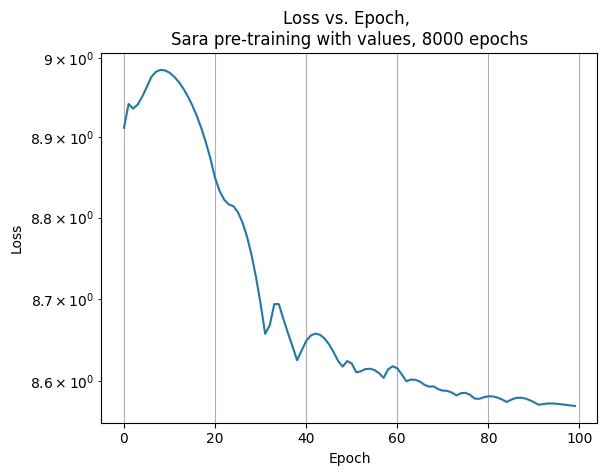

In [40]:
plt.plot(opt_sara_v8000l)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch, \n' \
    'Sara pre-training with values, 8000 epochs')
plt.yscale('log')
plt.grid()
plt.show()
